# Workshop 1 - Apply
    
In this notebook you will work on a homework assignment involving a Vierendeel frame.

Our matrix method implementation is now completely stored in a local package, consisting of three classes.

## Vierendeel frame

<center><figure>
  <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/vierendeel.png" WIDTH=400 ALIGN="center">
      </figure></center>

With:

- $h = 1$
- $b = 1$
- $EI_r = 10000$
- $EI_k = 1000$
- $EA  = 1\cdot 10^{10}$
- $H = 100$


In the first half of this course last quarter, you have learned that the deformation of Vierendeel frames (an example of which is shown above) can be obtained in a simplified way by assuming the global deformation can be described by a shear beam with equivalent stiffness given by:

$$
k = \frac{24}{h\left(\displaystyle\frac{h}{EI_k}+\frac{b}{EI_r}\right)}
$$

Now that you have the tools to solve the original frame problem using the Matrix Method, your task in this assignment is to investigate the validity of this equivalent shear beam model.

Note that the checks only had a single element. For this model you need to obtain $\mathbf{K}$ and $\mathbf{f}$ of all elements and add them to the correct locations in the global stiffness matrix and force vector. To do that, make use of the `global_dofs` function of the Element class and the `np.ix_` Numpy utility function. (Tip: refer back to what you did in the `constrain` function).

Once you have a solution, use SymPy / Maple / pen and paper to solve a shear beam problem with the equivalent stiffness given above (It is very similar to the simple extension problem above) and compare the horizontal displacement at the point of application of $H$ for the two models.

Investigate how the two models compare for different values of $EA$, ranging from very small (*e.g.* $1\cdot 10^{-5}$) to very large (*e.g.* $1\cdot10^{10}$). What explains the behavior you observe?

In [1]:
import numpy as np
import matrixmethod as mm
%config InlineBackend.figure_formats = ['svg']

In [2]:
mm.Node.clear()
mm.Element.clear()

## DEFINE VARIABLES
h = 1
b = 1
EIr = 10000
EIk = 1000
EA  = 1e10
H = 100

## CREATE NODES
nodes = [] # initialize an empty list of elements

nodes.append(mm.Node(0,0)) # node1
nodes.append(mm.Node(b,0)) # node2
nodes.append(mm.Node(b,-h)) # node3
nodes.append(mm.Node(0,-h)) # node4
# positive z axis is downwards

## CREATE ELEMENTS
elems = []  # initialize an empty list of elements

elems.append(mm.Element(nodes[0], nodes[1])) # element 1 joining node 1 and 2
elems.append(mm.Element(nodes[1], nodes[2])) # element 2 joining node 2 and 3
elems.append(mm.Element(nodes[2], nodes[3])) # element 3 joining node 3 and 4
elems.append(mm.Element(nodes[0], nodes[3])) # element 4 joining node 4 and 1

beams = {}  # dictionary
columns = {}  # dictionary
beams['EI'] = EIr  # define beam stiffness
beams['EA'] = EA # define beam stiffness
columns['EI'] = EIk # define column stiffness
columns['EA'] = EA # define column stiffness

elems[0].set_section (beams)  # define element 1 as a beam
elems[1].set_section (columns) # define element 2 as a column
elems[2].set_section (beams) # define element 3 as a beam
elems[3].set_section (columns) # define element 4 as a column

for elem in elems:
    print(elem)

## SET BOUNDARY CONDITIONS
con = mm.Constrainer()

con.fix_dof (nodes[0], 0)  # for node 1, contrain displacement in x
con.fix_dof (nodes[0], 1) # for node 1, contrain displacement in z
con.fix_dof (nodes[1], 1) # for node 2, contrain displacement in z

nodes[3].add_load ([H,0,0])  # for node 4, add Neumann BC - Force in x direction


Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[0. 0. 0.]
Element connecting:
node #1:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=-1,
 - degrees of freedom=[6, 7, 8],
 - load vector=[0. 0. 0.]
Element connecting:
node #1:
 This node has:
 - x coordinate=1,
 - z coordinate=-1,
 - degrees of freedom=[6, 7, 8],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x coordinate=0,
 - z coordinate=-1,
 - degrees of freedom=[9, 10, 11],
 - load vector=[0. 0. 0.]
Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x coordinate=

In [3]:
global_k = np.zeros ((3*len(nodes), 3*len(nodes)))  # initialize stiffness matrix size: dof*len(nodes), square
global_f = np.zeros (3*len(nodes)) 

print(global_k.shape) # 12x12 matrix
print(global_f.shape) # column vector

for elem in elems:
    elmat = elem.stiffness()  # elmat = element stiffness matrix
    idofs = elem.global_dofs() # global degrees of freedom of the element
    
    global_k[np.ix_(idofs,idofs)] += elmat  

#np.ix_(idofs, idofs) extracts the submatrix of global_k corresponding to this element’s DOFs.
#elmat is then added to the correct position in the global stiffness matrix.

for node in nodes:
    global_f[node.dofs] += node.p

(12, 12)
(12,)


In [ ]:
Kff, Ff = con.constrain ( global_k, global_f )
u = np.matmul ( np.linalg.inv(Kff), Ff )
print(u)

print(u.shape) # we removed 3 cause of dirichlet BCs

[-4.16667982e-04  4.99999539e-09 -4.16665674e-04  4.58333833e-03
  4.99999807e-09 -4.16675352e-04  4.58334333e-03 -4.99999806e-09
 -4.16677659e-04]
(9,)


So above we now have:
- Node 1 - moment dof [0]
- Node 2 - u and moment dof [1,2]
- Node 3 - all dof [3,4,5]
- Node 4 - all dof [6,7,8]  --> ref to u[6] in final answer below for the horizontal displacement in top-left node

which constructs a displacement vector consisting of 9 rows. 

In [39]:
#provided in case you want to solve the shear beam problem using SymPy
import sympy as sym

x, k, L, H = sym.symbols('x, k, L, H')
w = sym.Function('w')

#EOM - Shear Beam
ODE_shear = sym.Eq(w(x).diff(x, 2) *k, 0)
w = sym.dsolve(ODE_shear, w(x)).rhs
display(ODE_shear)

# Kinematic and Constitutive Relations
gamma = w.diff(x)
V = k * gamma

# Boundary Conditions
eq1 = sym.Eq(w.subs(x,0),0)
eq2 = sym.Eq(V.subs(x,L),H)
display(eq1)
display(eq2)

C_sol = sym.solve([eq1, eq2], sym.symbols('C1, C2'))
display(w.subs(C_sol))



Eq(k*Derivative(w(x), (x, 2)), 0)

Eq(C1, 0)

Eq(C2*k, H)

H*x/k

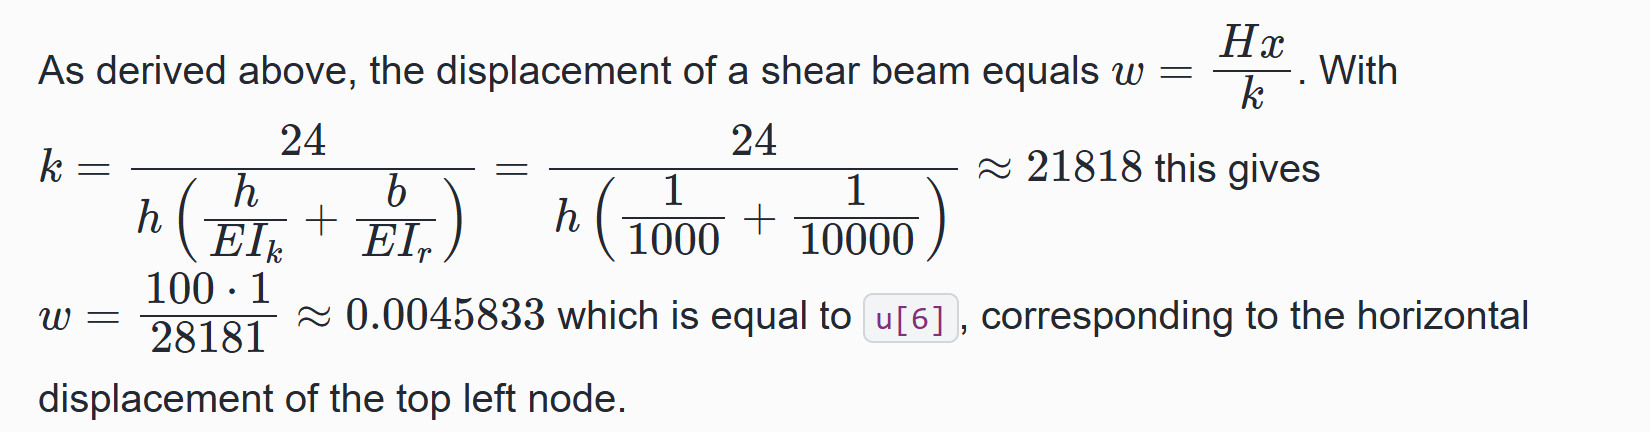